In [58]:
import torch
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [59]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, Dataset
valid_size = 0.2
batch_size = 128
num_workers = 0
#coverting to tensor
transform = transforms.Compose([
    transforms.Resize(227),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])
#choosing datasets
train_data = datasets.CIFAR10('data', train = True, download = True, transform = transform)
test_data = datasets.CIFAR10('data', train = False, download = True, transform = transform)
#obtaining training indices for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
#samplers for obtaining batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
#data loaders
train_loader = DataLoader(train_data , batch_size=batch_size, sampler=train_sampler , num_workers=num_workers)
valid_loader = DataLoader(train_data , batch_size=batch_size, sampler=valid_sampler , num_workers=num_workers)
test_loader = DataLoader(test_data , batch_size = batch_size, num_workers = num_workers)
#image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [60]:
import matplotlib.pyplot as plt
%matplotlib inline
#to unnormalize and display an image
def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))

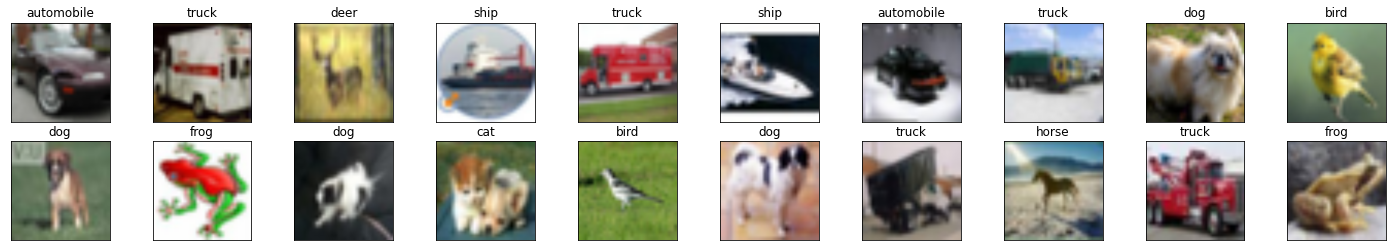

In [61]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks = [], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

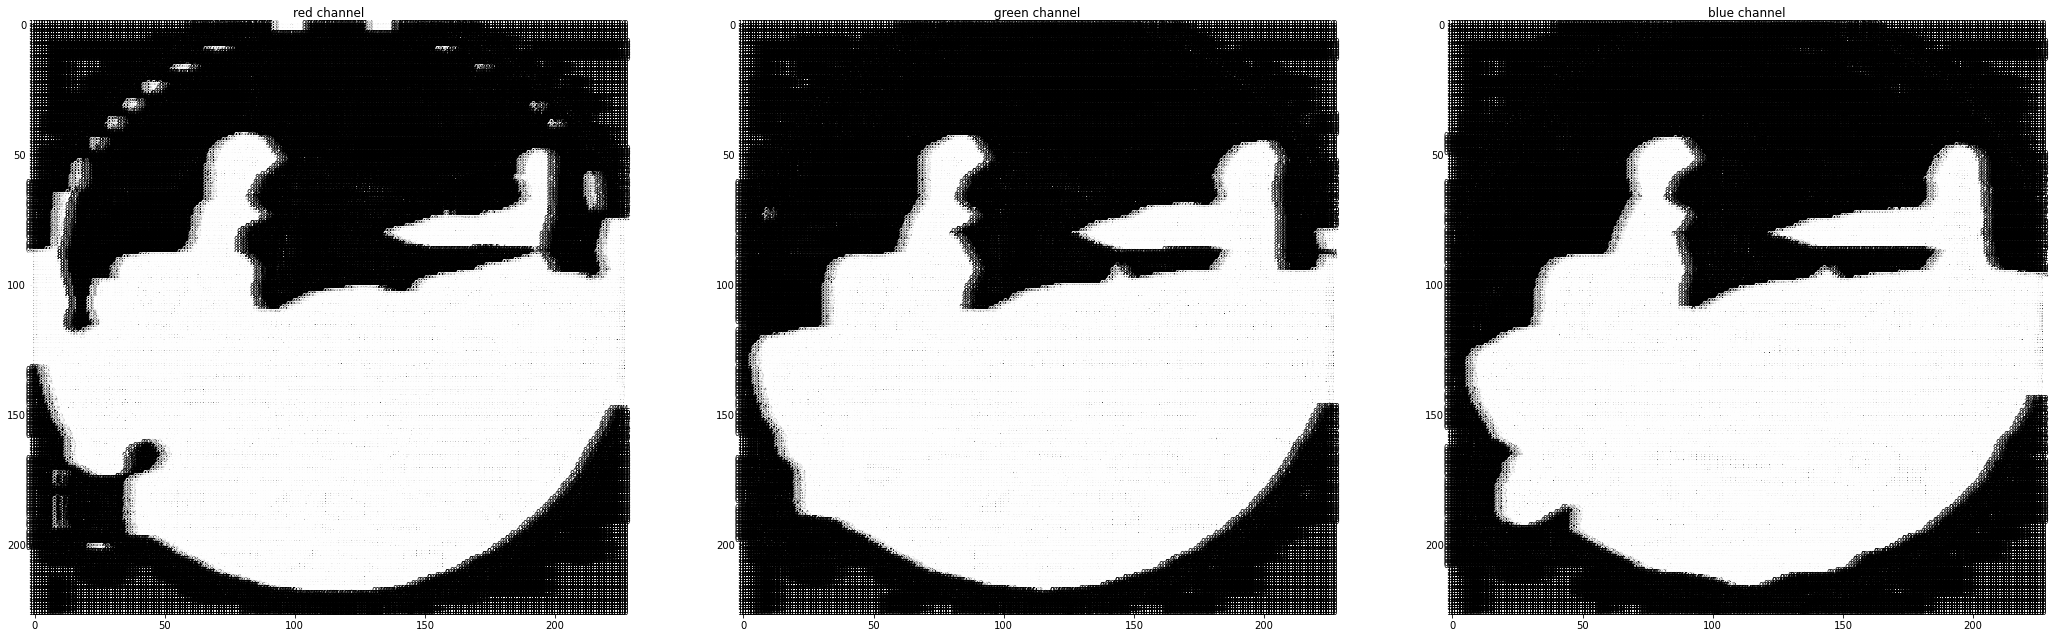

In [67]:
rgb_img = np.squeeze(images[3])
channels=['red channel', 'green channel', 'blue channel']
fig = plt.figure(figsize = (36,36))
for idx in np.arange(rgb_img.shape[0]):
    ax=fig.add_subplot(1,3,idx+1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width,height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x), horizontalalignment = 'center', verticalalignment = 'center', size=8, color='white' if img[x][y]<thresh else 'black')
            

In [63]:
import torch.nn as nn
import torch.nn.functional as F
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3,96,11,4)
        self.conv2 = nn.Conv2d(96,256,5,padding=2,groups=2)
        self.conv3 = nn.Conv2d(256,384,3,padding=1)
        self.conv4 = nn.Conv2d(384,384,3,padding=1, groups=2)
        self.conv5 = nn.Conv2d(384,256,3,padding=1, groups=2)
        self.fc1 = nn.Linear(256*6*6,4096)
        self.fc2 = nn.Linear(4096,4096)
        self.fc3 = nn.Linear(4096,num_classes)
 
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(F.relu(self.conv5(x)),(2,2))
        x = x.view(x.size(0),256*6*6)
        x = F.dropout(F.relu(self.fc1(x)),p=0.5)
        x = F.dropout(F.relu(self.fc2(x)),p=0.5)
        x = self.fc3(x)
        return x
device = torch.device("cuda")
print(device)
 
net = AlexNet()
net.to(device)


cuda


AlexNet(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=10, bias=True)
)

In [65]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.02, weight_decay=0.0005, momentum=0.9)
for epoch in range(1,16):
    loss = 0
    correct_predictions = 0
    total_predictions = 0
    for inputs, labels in train_loader:
        if torch.cuda.is_available():
           inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = net(inputs)
        loss_func = criterion(outputs, labels)
        loss += loss_func.item()
        prediction = outputs.argmax(1)
        correct_predictions += prediction.eq(labels.data).sum().item()
        total_predictions += labels.size(0)
        loss_func.backward()
        optimizer.step()   
    print('Epoch: %d  Loss: %.5f  Training Accuracy: %.2f %%' % (epoch, loss / (len(train_loader)), 100*(correct_predictions/total_predictions)))

Epoch: 1  Loss: 0.77185  Training Accuracy: 73.00 %
Epoch: 2  Loss: 0.63347  Training Accuracy: 77.89 %
Epoch: 3  Loss: 0.54193  Training Accuracy: 81.06 %
Epoch: 4  Loss: 0.43550  Training Accuracy: 84.64 %
Epoch: 5  Loss: 0.35706  Training Accuracy: 87.58 %
Epoch: 6  Loss: 0.28756  Training Accuracy: 90.07 %
Epoch: 7  Loss: 0.23161  Training Accuracy: 91.83 %
Epoch: 8  Loss: 0.19480  Training Accuracy: 93.40 %
Epoch: 9  Loss: 0.16925  Training Accuracy: 94.21 %
Epoch: 10  Loss: 0.13913  Training Accuracy: 95.28 %
Epoch: 11  Loss: 0.12060  Training Accuracy: 95.87 %
Epoch: 12  Loss: 0.10795  Training Accuracy: 96.42 %
Epoch: 13  Loss: 0.09616  Training Accuracy: 96.93 %
Epoch: 14  Loss: 0.07978  Training Accuracy: 97.38 %
Epoch: 15  Loss: 0.08123  Training Accuracy: 97.26 %


In [66]:
correct_predictions = 0
total_predictions = 0
for inputs, labels in test_loader:
    if torch.cuda.is_available():
           inputs, labels = inputs.cuda(), labels.cuda() 
           outputs = net(inputs)
           prediction = outputs.argmax(1)
           correct_predictions += prediction.eq(labels.data).sum().item()
           total_predictions += labels.size(0)
print('Test_Accuracy: %.2f %%' % (100 * (correct_predictions/total_predictions)))

Test_Accuracy: 77.65 %
